**Imports**

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import sys

sys.path.append('C:\\Coding\\customer-churn-prediction\\src')
from utils import download_telco_churn_dataset, split_test_train
from preprocessing import get_preproc

RND_SEED = 42

**Getting Preprocessing and Data**

In [2]:
telco = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X_train, X_test, y_train, y_test = split_test_train(telco)

preprocessing = get_preproc()

# Models

**Help Function**

Функция для оценки различных моделей на тестовой и тернировочных данных.

In [3]:
from sklearn.utils import class_weight

def fit_and_evaluate(models, cv=10):
    # Крафтим пайплайны для каждой модели
    pipelines = {}

    for name, model in models:
        pipelines[name] = (ImbPipeline([
            ("preproc", preprocessing.named_steps['preproc']),
            ("smote", preprocessing.named_steps['smote']),
            ("model", model)
        ]))

    metrics = {}

    # Оценивать модели будем по roc_auc score
    for name, model in pipelines.items():
        # Оценим сырые модельки на CV
        roc_auc_cv = cross_val_score(
            model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()

        model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)

        # Metrics evaluating
        roc_auc_test = roc_auc_score(y_test, y_pred_test)

        metrics[name] = {
            'roc_auc_test': roc_auc_test,
            'roc_auc_cv': roc_auc_cv,
        }

    sorted_metrics = dict(
        sorted(metrics.items(), key=lambda item: -item[1]['roc_auc_cv']))

    print(f"ТОП МОДЕЛЕЙ по ROC-AUC:")
    for name, metric in sorted_metrics.items():
        print(
            "\n" + f"{name} : \nAUC: {metric['roc_auc_cv']}")

## Models Comparation

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=RND_SEED, verbose=-1)

lr = LogisticRegression(random_state=RND_SEED, penalty='l2')

lin_svc = LinearSVC(C=1, random_state=RND_SEED)

gb = GradientBoostingClassifier(random_state=RND_SEED)

svc = SVC(C=1, random_state=RND_SEED)

rnd_forest = RandomForestClassifier(random_state=RND_SEED, n_jobs=-1)

xgb = XGBClassifier(random_state=RND_SEED, n_jobs=-1)

models = [
    ("Logistic Regression L2", lr),
    ("LightGBM", lgbm),
    ("RND Forest", rnd_forest),
    ("XGB Classifier", xgb),
    ("Gradient Boosting", gb),
    ("Linear SVC", lin_svc),
    ("SVC", svc),
]

In [5]:
fit_and_evaluate(models)

# Logistic Regression L2 : 
# AUC: 0.8373337846544386

ТОП МОДЕЛЕЙ по ROC-AUC:

Gradient Boosting : 
AUC: 0.8414493055602985

Logistic Regression L2 : 
AUC: 0.8373337846544386

Linear SVC : 
AUC: 0.8315463078822196

LightGBM : 
AUC: 0.828942697750384

RND Forest : 
AUC: 0.8222686919671831

SVC : 
AUC: 0.8216736611624962

XGB Classifier : 
AUC: 0.8166553502747138


Непосредственно в этой задаче мне важен `Recall` на положительном класса, то есть процент верно определенных `Churn`.

## Lin SVC + GB + Logist Regr

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint


def fine_tuning_models(models_data):
    for name, model_data in models_data.items():
        models_data[name] = {
            "pipeline": ImbPipeline([
                ("preproc", preprocessing.named_steps['preproc']),
                ("smote", preprocessing.named_steps['smote']),
                ("model", model_data["model"]),
            ]),
            "param_distrib": model_data["param_disturb"],
        }

        roc_auc_losses = cross_val_score(
            models_data[name]["pipeline"], X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
        print(f'{name} ROC-AUC:\n{pd.Series(roc_auc_losses).mean()}')

    print('=' * 50 + "Tuned models!!!" + '=' * 50)

    best_models = {}

    for name, model_data in models_data.items():
        rnd_search = RandomizedSearchCV(model_data["pipeline"], param_distributions=model_data["param_distrib"],
                                        n_iter=50, cv=5, n_jobs=-1, random_state=RND_SEED, scoring='roc_auc')
        rnd_search.fit(X_train, y_train)

        roc_auc_losses_cv = rnd_search.best_score_

        print(f'{name} AUC:\n{pd.Series(roc_auc_losses_cv).mean()}')

        best_models[name] = rnd_search.best_estimator_

    return best_models

In [7]:
pd_lin_svc = {
    "model__tol": uniform(1e-6, 1e-4),
    "model__C": loguniform(0.01, 5),
    "model__fit_intercept": [False],
}

pd_gb = {
    "model__learning_rate": loguniform(0.05, 0.1),
    "model__n_estimators": randint(100, 200),
    "model__max_depth": randint(3, 5),
    "model__max_features": ['sqrt', 'log2', None],
}

pd_lr = [
    {
        "model__penalty": ['l2'],
        "model__tol": uniform(1e-6, 1e-4),
        "model__C": loguniform(0.01, 2),
        "model__max_iter": randint(50, 500),
        "model__solver": ['lbfgs', 'liblinear'],
    }
]

models_data = {
    "Logistic Regression": {
        "model": lr,
        "param_disturb": pd_lr,
    },
    "Gradient Boosting": {
        "model": gb,
        "param_disturb": pd_gb,
    },
    "Linear SVC": {
        "model": lin_svc,
        "param_disturb": pd_lin_svc,
    },
}

In [8]:
best_models = fine_tuning_models(models_data)

# Logistic Regression ROC-AUC:
# 0.8373337846544386
# ==================================================Tuned models!!!==================================================
# Logistic Regression AUC:
# 0.8411944300018808

Logistic Regression ROC-AUC:
0.8373337846544386
Gradient Boosting ROC-AUC:
0.8414493055602985
Linear SVC ROC-AUC:
0.8315463078822196
==================================================Tuned models!!!==================================================
Logistic Regression AUC:
0.8411944300018808
Gradient Boosting AUC:
0.843016852952782
Linear SVC AUC:
0.8392486977418278


Тут лучше всего себя показала логистическая регрессия!

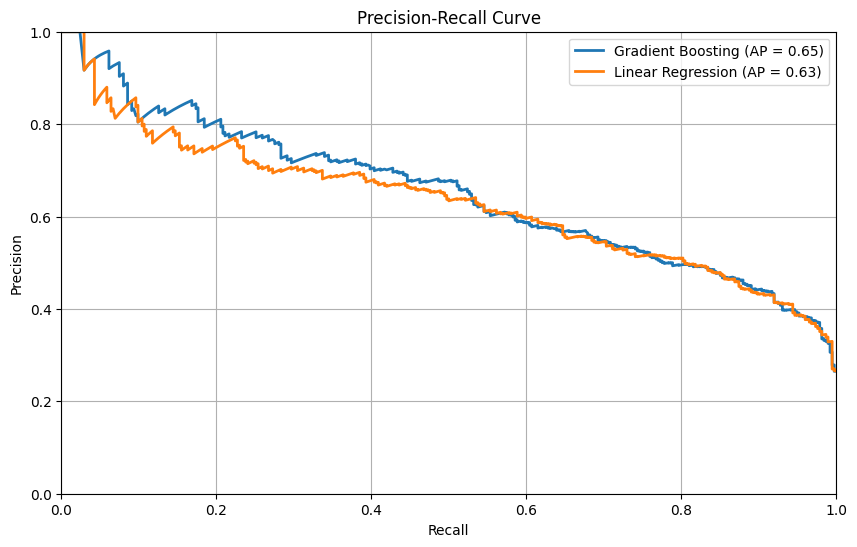

In [9]:
gb_tuned = best_models["Gradient Boosting"]
lr_tuned = best_models["Logistic Regression"]
lin_svc_tuned = best_models["Linear SVC"]

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

y_scores = gb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'Gradient Boosting (AP = {average_precision:.2f})')

y_scores = lr_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, linewidth=2, label=f'Linear Regression (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

In [10]:
from sklearn.model_selection import learning_curve, cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_cv = cross_val_predict(lr_tuned, X_train, y_train, cv=10, n_jobs=-1)
cm_cv = confusion_matrix(y_train, y_pred_cv)

cm_cv

array([[3145,  994],
       [ 350, 1145]])

In [25]:
def get_optimal_threshold(model, target='f1', target_score=0.8, help_metric='recall', help_metric_min_score=0.7):
    from sklearn.metrics import precision_recall_curve
    
    if (target not in ['f1', 'precision', 'recall']):
        raise ValueError("target must be 'f1', 'precision' or 'recall'.")
    
    if (help_metric not in ['precision', 'recall']):
        raise ValueError("target must be 'precision' or 'recall'.")
    
    def f1(precision_, recall_):
        if precision_ + recall_ == 0:
            return 0.0
        
        return 2 * (precision_ * recall_) / (precision_ + recall_)
    
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    f1s = []
    max_f1_score = 0
    max_f1_idx = 0

    for i in range(len(thresholds)):
        f1s.append(f1(precision[i], recall[i]))
        if max_f1_score < f1s[i]:
            if (help_metric is None):
                max_f1_score = f1s[i]
                max_f1_idx = i
            elif (help_metric == 'recall') and (recall[i] >= help_metric_min_score):
                max_f1_score = f1s[i]
                max_f1_idx = i
            elif (help_metric == 'precision') and (precision[i] >= help_metric_min_score):
                max_f1_score = f1s[i]
                max_f1_idx = i

    optimal_idx_recall = np.argmin(recall >= target_score)
    optimal_idx_precision = np.argmin(recall >= target_score)
    optimal_threshold_recall = thresholds[optimal_idx_recall]
    optimal_threshold_precision = thresholds[optimal_idx_precision]
    optimal_threshold_f1 = thresholds[max_f1_idx]

    if target == 'f1':
        return optimal_threshold_f1
    elif target == 'recall':
        return optimal_threshold_recall
    elif target == 'precision':
        return optimal_threshold_precision

In [29]:
from sklearn.model_selection import FixedThresholdClassifier

optimal_threshold_LR = get_optimal_threshold(model=lr_tuned, target='f1')
optimal_threshold_GB = get_optimal_threshold(model=gb_tuned, target='f1', help_metric_min_score=0.8)
 
lr_tuned = FixedThresholdClassifier(lr_tuned, threshold=optimal_threshold_LR)
lr_tuned.fit(X_train, y_train)
gb_tuned = FixedThresholdClassifier(gb_tuned, threshold=optimal_threshold_GB)
gb_tuned.fit(X_train, y_train)


y_pred_otimised_LR = lr_tuned.predict(X_test)
y_pred_otimised_GB = gb_tuned.predict(X_test)

In [30]:
print(f'LR THRESHOLD: {optimal_threshold_LR}')
print(f'F1: {f1_score(y_test, y_pred_otimised_LR)}')
print(f'P: {precision_score(y_test, y_pred_otimised_LR)}')
print(f'R: {recall_score(y_test, y_pred_otimised_LR)}')
print()
print(f'GB THRESHOLD: {optimal_threshold_GB}')
print(f'F1: {f1_score(y_test, y_pred_otimised_GB)}')
print(f'P: {precision_score(y_test, y_pred_otimised_GB)}')
print(f'R: {recall_score(y_test, y_pred_otimised_GB)}')

# THRESHOLD: 0.4636498354792728
# F1: 0.6237006237006237
# P: 0.5102040816326531
# R: 0.8021390374331551

LR THRESHOLD: 0.4636498354792728
F1: 0.6237006237006237
P: 0.5102040816326531
R: 0.8021390374331551

GB THRESHOLD: 0.4084219165707902
F1: 0.6182902584493042
P: 0.4920886075949367
R: 0.8315508021390374


In [34]:
y_pred_test = lr_tuned.predict(X_test)
y_pred_proba_test = lr_tuned.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred_test)

cm

# array([[747, 288],
#        [ 74, 300]])

array([[747, 288],
       [ 74, 300]])

# Визуализация ошибок модели (LR)

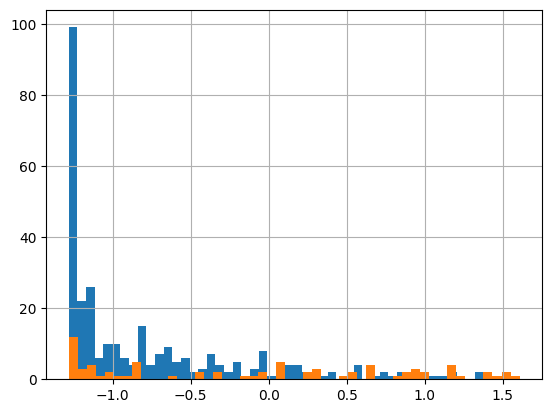

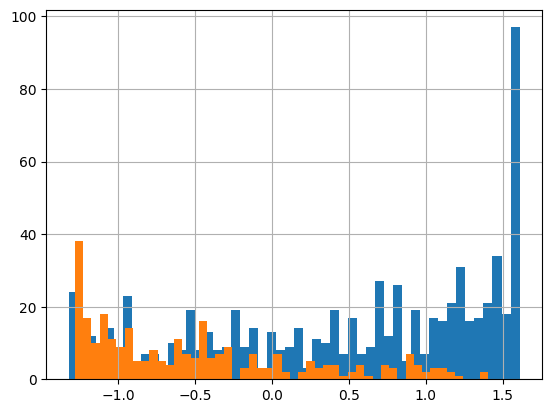

In [20]:
X_test_preprocessed = preprocessing[:-1].transform(X_test)

false_negative = X_test_preprocessed[
    (y_pred_test == 0) & (y_test == 1)
]
true_positive = X_test_preprocessed[
    (y_pred_test == 1) & (y_test == 1)
]
false_positive = X_test_preprocessed[
    (y_pred_test == 1) & (y_test == 0)
]
true_negative = X_test_preprocessed[
    (y_pred_test == 0) & (y_test == 0)
]

col = "num__tenure"
true_positive[col].hist(bins=50)
false_negative[col].hist(bins=50)
plt.show()

true_negative[col].hist(bins=50)
false_positive[col].hist(bins=50)
plt.show()

In [21]:
# Добавим метки для каждого типа предсказания
X_test_with_errors = preprocessing[:-1].transform(X_test)
X_test_with_errors['true_label'] = y_test
X_test_with_errors['predicted_label'] = y_pred_test
X_test_with_errors['error_type'] = 'correct'
X_test_with_errors.loc[(y_pred_test == 0) & (y_test == 1), 'error_type'] = 'false_negative'
X_test_with_errors.loc[(y_pred_test == 1) & (y_test == 0), 'error_type'] = 'false_positive'
X_test_with_errors.loc[(y_pred_test == 1) & (y_test == 1), 'error_type'] = 'true_positive'
X_test_with_errors.loc[(y_pred_test == 0) & (y_test == 0), 'error_type'] = 'true_negative'

# Сравним средние значения признаков по группам
error_summary = X_test_with_errors.groupby('error_type').mean().T
print(error_summary)

error_type                                     false_negative  false_positive  \
num__MonthlyCharges                                 -0.073415        0.326497   
num__tenure                                         -0.093456       -0.497756   
num__MonthlyCharges tenure                           0.089989       -0.249201   
sqrt__TotalCharges                                   0.016642       -0.215432   
yes_no__Partner                                      0.513514        0.329861   
yes_no__Dependents                                   0.405405        0.125000   
yes_no__PhoneService                                 0.891892        0.930556   
yes_no__MultipleLines                                0.378378        0.461806   
yes_no__OnlineSecurity                               0.445946        0.142361   
yes_no__OnlineBackup                                 0.378378        0.260417   
yes_no__DeviceProtection                             0.310811        0.253472   
yes_no__TechSupport         

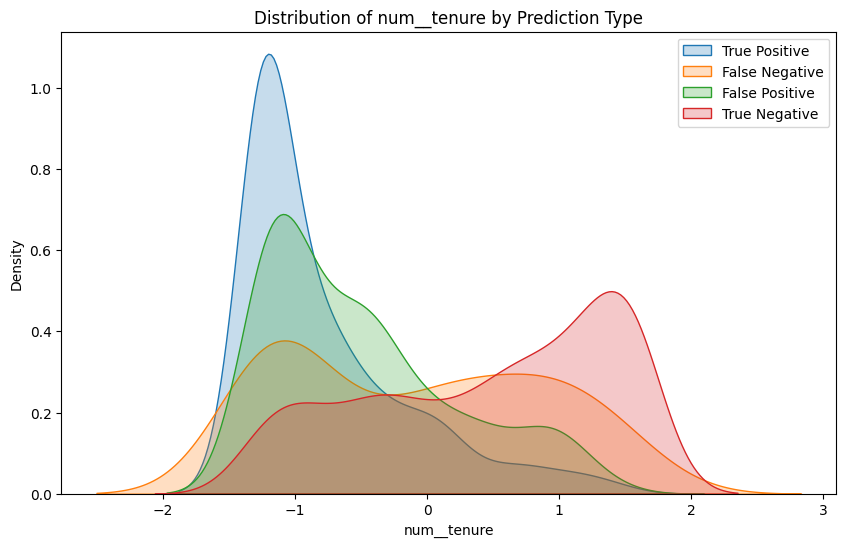

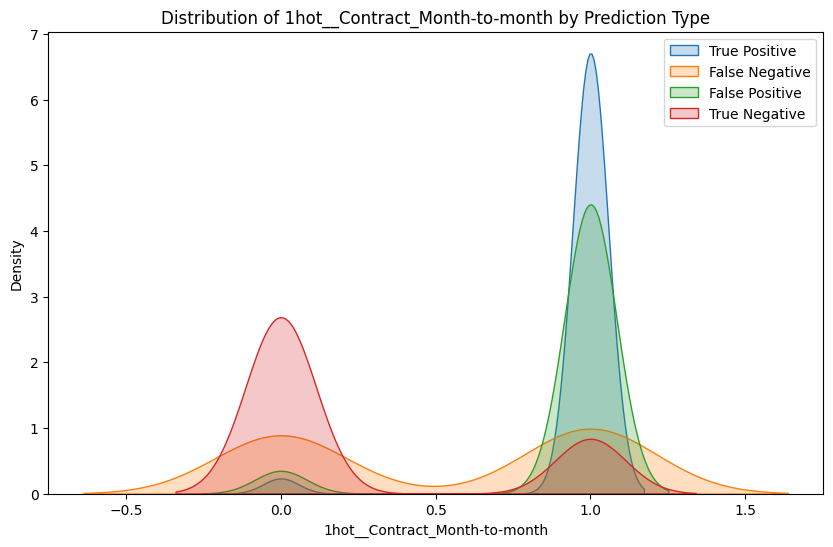

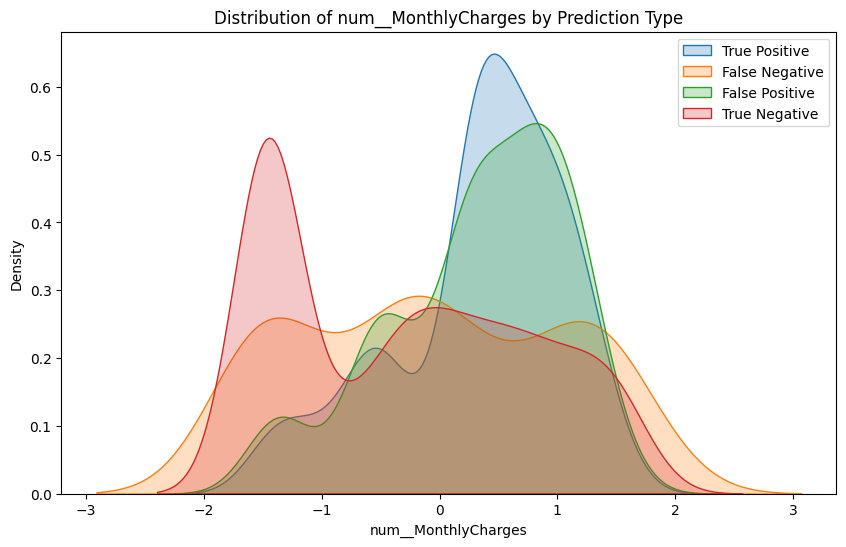

In [22]:
# Выберем несколько наиболее важных признаков (если знаете)
# Или проанализируйте все по очереди
important_features = ['num__tenure', '1hot__Contract_Month-to-month', 'num__MonthlyCharges'] # замените на ваши
import seaborn as sns

for feature in important_features:
    plt.figure(figsize=(10, 6))
    
    # Сравним распределения для разных типов ошибок
    sns.kdeplot(data=true_positive[feature], label='True Positive', fill=True)
    sns.kdeplot(data=false_negative[feature], label='False Negative', fill=True)
    sns.kdeplot(data=false_positive[feature], label='False Positive', fill=True)
    sns.kdeplot(data=true_negative[feature], label='True Negative', fill=True)
    
    plt.title(f'Distribution of {feature} by Prediction Type')
    plt.legend()
    plt.show()

Из графиков не понятно, почему наша модель ошибается. Скорее всего из-за линейной неразделимости классов.

# Ансамблирование лучших моделей

Возьму только две лучшие модели - Gradient Boosting, Logistic Regression.

In [45]:
from sklearn.ensemble import VotingClassifier

final_system = VotingClassifier(estimators=[('lr', lr_tuned), ('gb', gb_tuned)], voting='soft', weights=[2, 2])

final_system.fit(X_train, y_train)
y_pred_final = final_system.predict(X_test)

lr_tuned.fit(X_train, y_train)
y_pred_lr = lr_tuned.predict(X_test)

print(f'MODEL: LR')
print(f'F1: {f1_score(y_test, y_pred_lr)}')
print(f'P: {precision_score(y_test, y_pred_lr)}')
print(f'R: {recall_score(y_test, y_pred_lr)}')
print()
print(f'MODEL: ENSEMBLE')
print(f'F1: {f1_score(y_test, y_pred_final)}')
print(f'P: {precision_score(y_test, y_pred_final)}')
print(f'R: {recall_score(y_test, y_pred_final)}')

MODEL: LR
F1: 0.6237006237006237
P: 0.5102040816326531
R: 0.8021390374331551

MODEL: ENSEMBLE
F1: 0.6210640608034745
P: 0.5228519195612431
R: 0.7647058823529411


Стало хуже, надо понять почему.